# **Data Bootcamp Final Project**

### By Zachary Knudsen and Lucas Osiecki

Source: https://www.kaggle.com/datasets/thedevastator/uncovering-betting-patterns-in-the-premier-leagu?select=2011.csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf
from numpy import random
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor as knn
from sklearn.ensemble import RandomForestClassifier as rf_clf
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

from plotnine import *
%matplotlib inline

In [2]:
# download all data
df1= pd.read_csv('2011.csv')
df2= pd.read_csv('2012.csv')
df3= pd.read_csv('2013.csv')
df4= pd.read_csv('2014.csv')
df5= pd.read_csv('2015.csv')
df6= pd.read_csv('2016.csv')
df7= pd.read_csv('2017.csv')
df8= pd.read_csv('2018.csv')
df9= pd.read_csv('2019.csv')
df10= pd.read_csv('2020.csv')
df11= pd.read_csv('2021.csv')

# concatenate data sets to make 11 season dataframe with all data
EPLstats11yr = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11])

# get rid of unnecessary columns
columnsToKeep = ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
EPLstats11yr = EPLstats11yr.drop(columns= [col for col in EPLstats11yr if col not in columnsToKeep])
EPLstats11yr

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,E0,13/08/11,Blackburn,Wolves,1,2,A,1,1,D,...,8,4,14,10,12,6,4,2,0,0
1,E0,13/08/11,Fulham,Aston Villa,0,0,D,0,0,D,...,9,1,10,18,2,3,2,4,0,0
2,E0,13/08/11,Liverpool,Sunderland,1,1,D,1,0,H,...,4,6,17,12,6,3,4,4,0,0
3,E0,13/08/11,Newcastle,Arsenal,0,0,D,0,0,D,...,1,4,9,11,2,5,3,5,0,1
4,E0,13/08/11,QPR,Bolton,0,4,A,0,1,A,...,7,7,9,16,3,2,1,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,E0,22/05/2022,Crystal Palace,Man United,1,0,H,1,0,H,...,3,4,12,22,3,6,2,4,0,0
376,E0,22/05/2022,Leicester,Southampton,4,1,H,0,0,D,...,6,2,10,5,3,3,0,1,0,0
377,E0,22/05/2022,Liverpool,Wolves,3,1,H,1,1,D,...,8,5,6,3,5,3,1,0,0,0
378,E0,22/05/2022,Man City,Aston Villa,3,2,H,0,1,A,...,5,2,5,11,13,1,0,1,0,0


### Abbreviation Key

* HomeTeam	Name of the home team. (String)
* AwayTeam	Name of the away team. (String)
* FTR	Full time result. (String)
* HS	Home team shots. (Integer)
* AS	Away team shots. (Integer)
* HF	Home team fouls. (Integer)
* AF	Away team fouls. (Integer)
* HC	Home team corners. (Integer)
* AC	Away team corners. (Integer)
* HY	Home team yellow cards. (Integer)
* AY	Away team yellow cards. (Integer)

**BIG IDEA:** Create a model that predicts each team's relative performance given their average shots, corners, fouls, and yellow cards per game... each of these statistics can have implications on the number of goals scored for and against, potentially impacting the full time result.

Every team plays 38 games per season. 

In [3]:
# get rid of home and away, focus on win vs loss
windf1= EPLstats11yr[EPLstats11yr['FTR'] == 'H']
windf1= windf1[['HS', 'HF', 'HC', 'HY', 'HomeTeam']]
windf1['Result'] = 'W'

windf2= EPLstats11yr[EPLstats11yr['FTR'] == 'A']
windf2= windf2[['AS', 'AF', 'AC', 'AY', 'AwayTeam']]
windf2['Result'] = 'W'

windf1= windf1.rename(columns= {'HS': 'Shots','HF': 'Fouls Committed', 'HC': 'Corners',
                                'HY': 'Yellow Cards', 'HomeTeam': 'Team'})
windf2= windf2.rename(columns= {'AS': 'Shots', 'AF': 'Fouls Committed', 'AC': 'Corners',
                                'AY': 'Yellow Cards', 'AwayTeam': 'Team'})
windf= pd.concat([windf1, windf2])

lossdf1= EPLstats11yr[EPLstats11yr['FTR'] == 'H']
lossdf1= lossdf1[['AS', 'AF', 'AC', 'AY', 'AwayTeam']]
lossdf1['Result'] = 'L'

lossdf2= EPLstats11yr[EPLstats11yr['FTR'] == 'A']
lossdf2= lossdf2[['HS', 'HF', 'HC', 'HY', 'HomeTeam']]
lossdf2['Result'] = 'L'

lossdf1= lossdf1.rename(columns= {'AS': 'Shots', 'AF': 'Fouls Committed', 'AC': 'Corners',
                                  'AY': 'Yellow Cards', 'AwayTeam': 'Team'})
lossdf2= lossdf2.rename(columns= {'HS': 'Shots', 'HF': 'Fouls Committed', 'HC': 'Corners',
                                  'HY': 'Yellow Cards', 'HomeTeam': 'Team'})
lossdf= pd.concat([lossdf1, lossdf2])

resultsdf= pd.concat([windf, lossdf])
resultsdf

,Shots,Fouls Committed,Corners,Yellow Cards,Team,Result
8,26,9,7,0,Man City,W
10,9,9,5,3,Aston Villa,W
11,22,12,7,2,Chelsea,W
17,17,7,7,2,Wolves,W
18,27,12,11,1,Man United,W
...,...,...,...,...,...,...
364,10,8,5,0,Everton,L
366,4,6,1,2,Southampton,L
371,14,11,3,2,Brentford,L
373,12,8,8,1,Burnley,L


This data frame above gives the shots, fouls committed, yellow cards, and corners for every single team in each game from 2011-2022. This model only includes wins and losses from these seasons, because including draws would dilute the impact of each statistic on the outcome of a team's performance. This is helpful because it means that the win/loss proportion of this table is 50%, which means that if we average out each statistic, we will get the averaged statistics for a 50% chance of winning or losing... this will help to build our team valuation model, where we predict how well teams will do based on their average statistics per match.

In [10]:
resultsdf.Result = pd.Categorical(resultsdf.Result)
resultsdf['Result_code'] = resultsdf.Result.cat.codes

resultsdf= resultsdf.dropna().reset_index()

features= ['Shots', 'Fouls Committed', 'Corners', 'Yellow Cards']
X= resultsdf[features]
y= resultsdf['Result_code']

In [11]:
train, test = train_test_split(resultsdf, 
                               test_size=0.2, 
                               random_state=40,
                               shuffle=True)

rfrandompred=rf_clf().fit(y=resultsdf['Result_code'],
                       X=resultsdf[features]).predict(resultsdf[features])
rfrandompredprob=rf_clf().fit(y=resultsdf['Result_code'],
                       X=resultsdf[features]).predict_proba(resultsdf[features])

rfdf1=pd.DataFrame()
rfdf1['class_predicted']= rfrandompred
rfdf1['prob_0'], rfdf1['prob_1']=rfrandompredprob.T
rfdf1['True'] = resultsdf['Result_code']

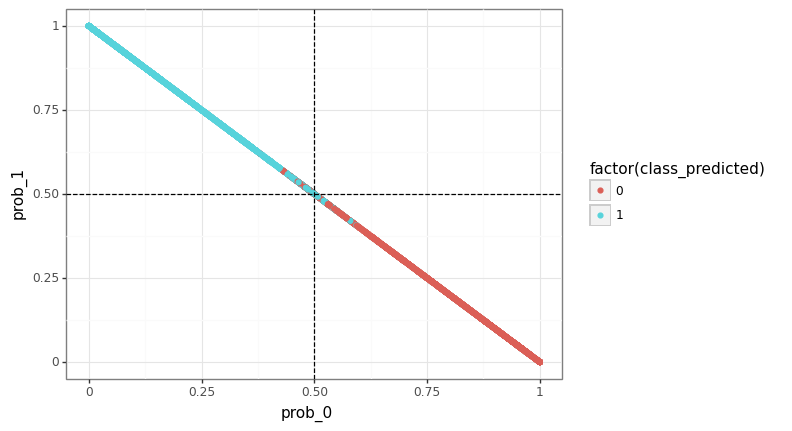

<ggplot: (8779446886301)>

In [12]:
(ggplot(rfdf1, aes(x='prob_0', y='prob_1', color='factor(class_predicted)'))+
geom_point()+
geom_hline(yintercept=0.5, linetype='dashed')+
 geom_vline(xintercept=0.5, linetype='dashed')+
 theme_bw())

In [13]:
print(classification_report(y_pred=rfdf1['class_predicted'], y_true=rfdf1['True'].astype(int)))

              precision    recall  f1-score   support

           0       0.88      0.89      0.89      3184
           1       0.89      0.88      0.89      3184

    accuracy                           0.89      6368
   macro avg       0.89      0.89      0.89      6368
weighted avg       0.89      0.89      0.89      6368



In [14]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Define the features and target variables
features = ['Shots', 'Fouls Committed', 'Corners', 'Yellow Cards']
X = resultsdf[features]
y = resultsdf['Result_code']

# Create a Random Forest Classifier object
rf_clf = RandomForestClassifier()

# Fit the model on the data
rf_clf.fit(X, y)

# Get the feature importance scores
importances = rf_clf.feature_importances_

# Create a DataFrame to display the results
feature_importances = pd.DataFrame({'feature': features,
                                    'importance': importances}).\
                                      sort_values('importance', ascending = False)

# Print the feature importances
print(feature_importances)

           feature  importance
1  Fouls Committed    0.334369
0            Shots    0.308605
2          Corners    0.226899
3     Yellow Cards    0.130127


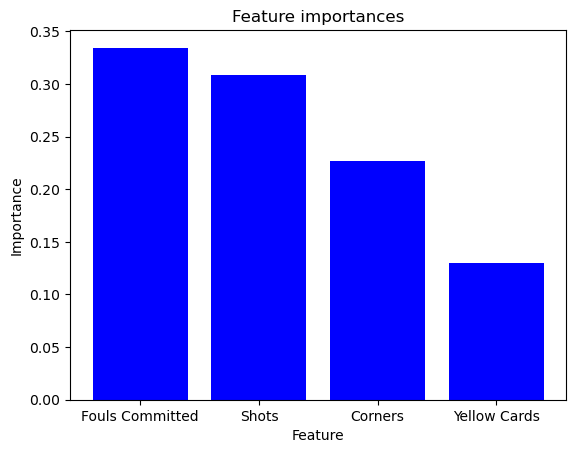

In [36]:
importances = pd.DataFrame({
    'Feature': ['Fouls Committed', 'Shots', 'Corners', 'Yellow Cards'],
    'Importance': [00.334369, 0.308605, 0.226899, 0.130127]})

fig, ax = plt.subplots()

ax.bar(importances['Feature'], importances['Importance'], color= 'blue')

ax.set_title("Feature importances")
ax.set_xlabel("Feature")
ax.set_ylabel("Importance")

plt.show()

Now that we have how important each feature is, let's find the average of each statistic per match, and see what these averages lead to in terms of win percentage.

In [5]:
# average shots per game per team
print(resultsdf['Shots'].sum()/ 6368, 'avg shots per game')

12.74199120603015 avg shots per game


In [6]:
# average fouls committed per game per team
print(resultsdf['Fouls Committed'].sum()/ 6368, 'avg fouls committed per game')

10.558888190954773 avg fouls committed per game


In [7]:
# average corner kicks per game per team
print(resultsdf['Corners'].sum()/ 6368, 'avg corner kicks per game')

5.2917713567839195 avg corner kicks per game


In [8]:
# average yellow cards per game per team
print(resultsdf['Yellow Cards'].sum()/ 6368, 'avg yellow cards per game')

1.57553391959799 avg yellow cards per game


Win proportion with these averaged statistics is 50%... I have the same amount of wins as losses in my dataframe...

Now, let's create a model that can predict which teams will perform better (win more/ lose less) than others!

Valuation: ((Team avg shots/ game - 12.74199120603015)(0.308605)+ (Team avg fouls committed/ game - 10.558888190954773)(0.334369)+ (Team avg corner kicks/ game - 5.2917713567839195)(0.226899) + (Team avg yellow cards/ game - 1.57553391959799)(0.130127))

In [9]:
teamWins= resultsdf.groupby('Team')[['Shots', 'Fouls Committed', 'Corners', 'Yellow Cards']].sum()
teamWins

,Shots,Fouls Committed,Corners,Yellow Cards
Team,,,,
Arsenal,4771,3285,1962,514
Aston Villa,2582,2594,1112,442
Blackburn,343,340,138,58
Bolton,366,356,176,46
Bournemouth,1666,1393,786,217
Brentford,364,302,132,48
Brighton,1326,1382,567,178
Burnley,2014,1993,867,312
Cardiff,698,585,307,89


Because of relegation, I will see how many years each team played in the EPL.

In [11]:
EPLstats11yr['Date']= pd.to_datetime(EPLstats11yr['Date'])
EPLstats11yr['Year'] = EPLstats11yr['Date'].dt.year

yearteam= EPLstats11yr.groupby('HomeTeam')['Year'].unique().reset_index()
yearteam["NumYears"] = yearteam["Year"].apply(lambda x: len(x))
yearteam['NumSeasons']= yearteam['NumYears']-1
yearteam.drop(columns= 'NumYears', inplace= True)
yearteam.rename(columns= {'HomeTeam': 'Team'}, inplace= True)
yearteam.set_index('Team', inplace= True)
yearteam

,Year,NumSeasons
Team,,
Arsenal,"[2011, 2012, 2013, 2014, 2015, 2016, 2017, 201...",11
Aston Villa,"[2011, 2012, 2013, 2014, 2015, 2016, 2019, 202...",9
Blackburn,"[2011, 2012]",1
Bolton,"[2011, 2012]",1
Bournemouth,"[2015, 2016, 2017, 2018, 2019, 2020]",5
Brentford,"[2021, 2022]",1
Brighton,"[2017, 2018, 2019, 2020, 2021, 2022]",5
Burnley,"[2014, 2015, 2016, 2017, 2018, 2019, 2020, 202...",8
Cardiff,"[2013, 2014, 2018, 2019]",3


In [12]:
avgstatsteamwins= pd.merge(teamWins, yearteam, on='Team', how='inner')
avgstatsteamwins['AvgShots']= avgstatsteamwins['Shots']/ yearteam['NumSeasons']
avgstatsteamwins['AvgFouls']= avgstatsteamwins['Fouls Committed']/ yearteam['NumSeasons']
avgstatsteamwins['AvgCorners']= avgstatsteamwins['Corners']/ yearteam['NumSeasons']
avgstatsteamwins['AvgYellowCards']= avgstatsteamwins['Corners']/ yearteam['NumSeasons']
avgstatsteamwins.drop(columns= {'Shots', 'Fouls Committed', 'Corners', 'Yellow Cards',
                                'Year', 'NumSeasons'}, inplace= True)

In [13]:
avgstatsteamwins # shows each team's average statistics per season

,AvgShots,AvgFouls,AvgCorners,AvgYellowCards
Team,,,,
Arsenal,433.727273,298.636364,178.363636,178.363636
Aston Villa,286.888889,288.222222,123.555556,123.555556
Blackburn,343.000000,340.000000,138.000000,138.000000
Bolton,366.000000,356.000000,176.000000,176.000000
Bournemouth,333.200000,278.600000,157.200000,157.200000
Brentford,364.000000,302.000000,132.000000,132.000000
Brighton,265.200000,276.400000,113.400000,113.400000
Burnley,251.750000,249.125000,108.375000,108.375000
Cardiff,232.666667,195.000000,102.333333,102.333333


In [14]:
avggamestats= avgstatsteamwins
avggamestats['AvgShotsGame']= avggamestats['AvgShots']/ 38
avggamestats['AvgFoulsGame']= avggamestats['AvgFouls']/ 38
avggamestats['AvgCornersGame']= avggamestats['AvgCorners']/ 38
avggamestats['AvgYCGame']= avggamestats['AvgYellowCards']/ 38
avggamestats.drop(columns= {'AvgShots', 'AvgFouls', 'AvgCorners', 'AvgYellowCards'}, inplace= True)

In [15]:
avggamestats # this shows each team's average statistics per game from 2011-2022

,AvgShotsGame,AvgFoulsGame,AvgCornersGame,AvgYCGame
Team,,,,
Arsenal,11.413876,7.858852,4.693780,4.693780
Aston Villa,7.549708,7.584795,3.251462,3.251462
Blackburn,9.026316,8.947368,3.631579,3.631579
Bolton,9.631579,9.368421,4.631579,4.631579
Bournemouth,8.768421,7.331579,4.136842,4.136842
Brentford,9.578947,7.947368,3.473684,3.473684
Brighton,6.978947,7.273684,2.984211,2.984211
Burnley,6.625000,6.555921,2.851974,2.851974
Cardiff,6.122807,5.131579,2.692982,2.692982


Now that we have each team's averaged statistics per season, let's see what our model predicts for each team's performance!

In [16]:
avggamestats['Performance Valuation'] = (avggamestats['AvgShotsGame'] - 12.74199120603015) * 0.308605 
+ (avggamestats['AvgFoulsGame'] - 10.558888190954773) * 0.334369 
+ (avggamestats['AvgCornersGame'] - 5.2917713567839195) * 0.226899
+ (avggamestats['AvgYCGame'] - 1.57553391959799) * 0.130127

avggamestats['Performance Valuation'] = avggamestats['Performance Valuation'] + 10

avggamestats.sort_values('Performance Valuation', ascending= False).head(10)

,AvgShotsGame,AvgFoulsGame,AvgCornersGame,AvgYCGame,Performance Valuation
Team,,,,,
Man City,14.918660,8.406699,6.107656,6.107656,10.671731
Liverpool,12.803828,7.401914,5.086124,5.086124,10.019083
Chelsea,12.165072,7.956938,4.641148,4.641148,9.821960
Tottenham,11.861244,8.277512,4.803828,4.803828,9.728197
Arsenal,11.413876,7.858852,4.693780,4.693780,9.590137
Man United,10.533493,8.377990,4.287081,4.287081,9.318446
Leeds,10.236842,9.105263,4.000000,4.000000,9.226898
Bolton,9.631579,9.368421,4.631579,4.631579,9.040111
Brentford,9.578947,7.947368,3.473684,3.473684,9.023869


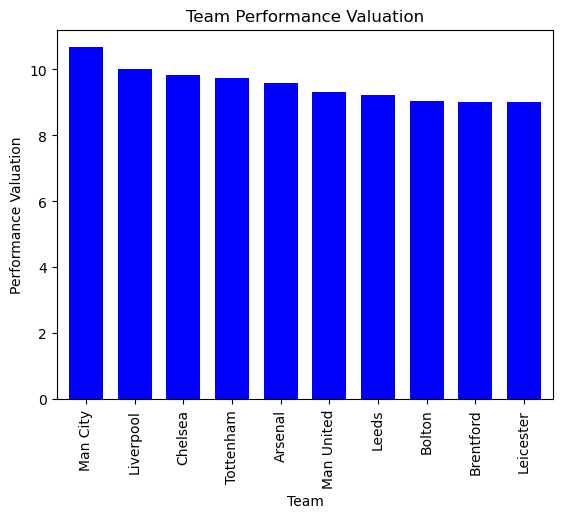

In [31]:
# create the dataframe
data = {'Team': ['Man City', 'Liverpool', 'Chelsea', 'Tottenham', 'Arsenal', 'Man United', 'Leeds', 'Bolton', 'Brentford', 'Leicester'],
        'AvgShotsGame': [14.918660, 12.803828, 12.165072, 11.861244, 11.413876, 10.533493, 10.236842, 9.631579, 9.578947, 9.565789],
        'AvgFoulsGame': [8.406699, 7.401914, 7.956938, 8.277512, 7.858852, 8.377990, 9.105263, 9.368421, 7.947368, 8.003289],
        'AvgCornersGame': [6.107656, 5.086124, 4.641148, 4.803828, 4.693780, 4.287081, 4.000000, 4.631579, 3.473684, 4.121711],
        'AvgYCGame': [6.107656, 5.086124, 4.641148, 4.803828, 4.693780, 4.287081, 4.000000, 4.631579, 3.473684, 4.121711],
        'Performance Valuation': [10.671731, 10.019083, 9.821960, 9.728197, 9.590137, 9.318446, 9.226898, 9.040111, 9.023869, 9.019808]}

df = pd.DataFrame(data)
df = df.set_index('Team')

# sort the dataframe by performance valuation
df = df.sort_values(by='Performance Valuation', ascending=False)

# create the bar graph
ax = df['Performance Valuation'].plot(kind='bar', color='blue', width=0.7)

# set the chart title and axis labels
ax.set_title('Team Performance Valuation')
ax.set_xlabel('Team')
ax.set_ylabel('Performance Valuation')

# show the chart
plt.show()

Now, let's compare this to each team's actual win percentage!

In [27]:
team_data = resultsdf.groupby("Team")

wins = team_data["Result"].apply(lambda x: (x == 'W').sum())
losses = team_data["Result"].apply(lambda x: (x == 'L').sum())

proportion = wins / (wins+losses)

result_df = pd.DataFrame({
    'Wins': wins,
    'Losses': losses,
    'Win Proportion': proportion
})

result_df = result_df.sort_values('Win Proportion', ascending=False)

result_df.head(10)

,Wins,Losses,Win Proportion
Team,,,
Man City,290,64,0.819209
Liverpool,243,77,0.759375
Chelsea,235,88,0.727554
Man United,231,88,0.724138
Tottenham,228,104,0.686747
Arsenal,225,106,0.679758
Leicester,125,109,0.534188
Everton,161,144,0.527869
West Ham,133,152,0.466667


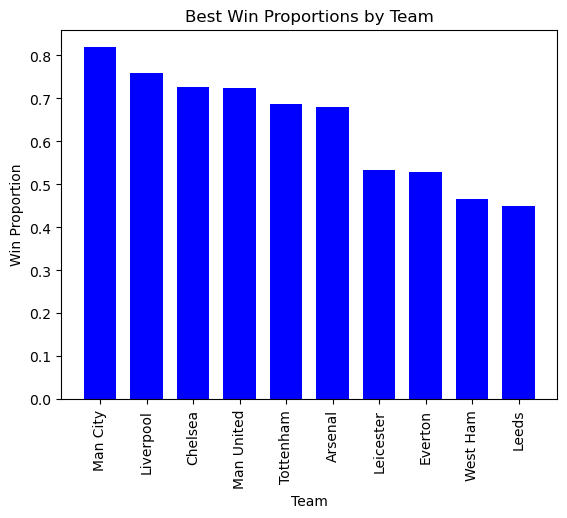

In [32]:
# Create a new figure and axis
fig, ax = plt.subplots()

# Sort the data by win proportion in descending order
sorted_df = result_df.sort_values('Win Proportion', ascending=False)

# Get the top ten teams by win proportion
top_ten = sorted_df[:10]

# Create a vertical bar plot
ax.bar(top_ten.index, top_ten['Win Proportion'], color= 'blue', width= 0.7)

# Set the axis labels and title
ax.set_xlabel('Team')
ax.set_ylabel('Win Proportion')
ax.set_title('Best Win Proportions by Team')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.show()

My model predicted 8 out of the 10 teams listed in the teams with the highest win proportions over the span of 11 seasons. My model predicted the top 3 teams perfectly as well. Although not 100% accurate, I think my model still is a strong measure of a team's relative performance.